[*********************100%***********************]  5 of 5 completed


Optimal Portfolio Weights:
BTC-USD: 62.99%
ETH-USD: 6.40%
SOL-USD: 2.17%
LINK-USD: 3.04%
BNB-USD: 4.59%


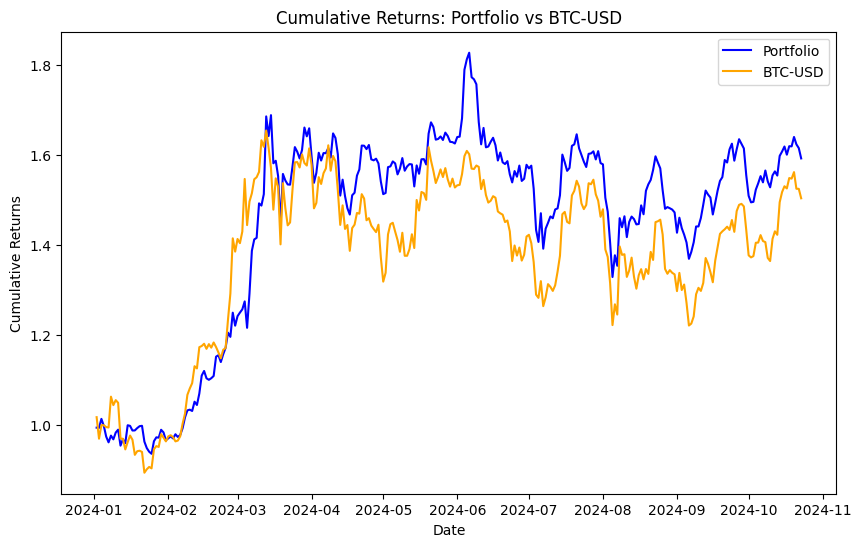

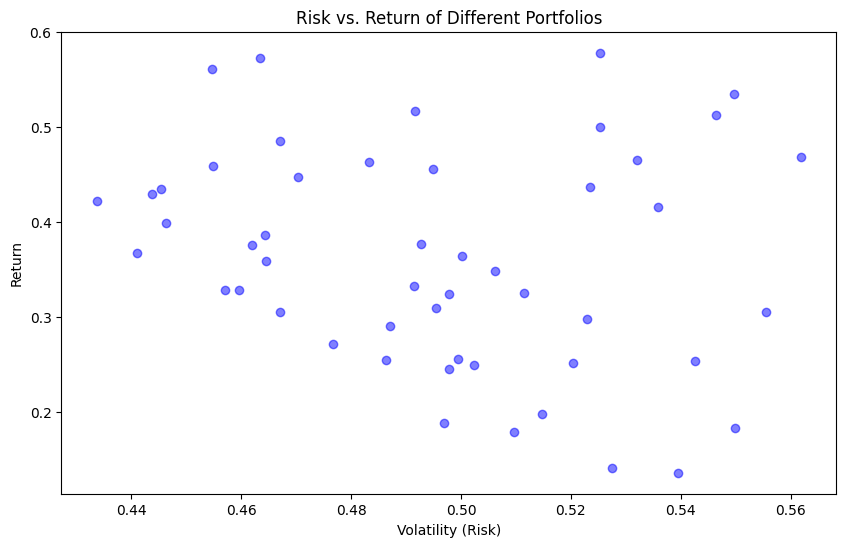

In [5]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Genetic Algorithm parameters and portfolio settings defined in main function
def main():
    # Parameters
    start_date = "2024-01-01"
    end_date = "2024-10-24"
    assets = ["BTC-USD", "ETH-USD", "SOL-USD", "LINK-USD", "BNB-USD"]
    population_size = 50
    generations = 100
    mutation_rate = 0.05

    # Fetch data
    data = fetch_data(assets, start_date, end_date)
    returns = calculate_daily_returns(data)

    # Ensure there is enough data
    if returns.empty or returns.shape[0] < 10:
        print("Not enough data available for analysis. Please choose a different date range or assets.")
        return

    # Run GA to find optimal weights
    best_weights = genetic_algorithm(returns, population_size, generations, mutation_rate)

    # Display and plot results
    if best_weights is not None and sum(best_weights) > 0:
        display_optimal_weights(assets, best_weights)
        plot_cumulative_returns(returns, best_weights)
        plot_risk_return(returns, initialize_population(population_size, returns.shape[1]))
    else:
        print("No valid solution found.")

def fetch_data(assets, start_date, end_date):
    data = yf.download(assets, start=start_date, end=end_date)['Adj Close']
    return data

def calculate_daily_returns(data):
    returns = data.pct_change().dropna()
    return returns

def genetic_algorithm(returns, population_size, generations, mutation_rate):
    num_assets = returns.shape[1]
    population = initialize_population(population_size, num_assets)

    for generation in range(generations):
        fitness_scores = np.array([fitness_function(individual, returns) for individual in population])
        if not fitness_scores.any() or max(fitness_scores) <= 0:
            best_individuals = population[:len(population) // 4]  # Keep top 25%
            new_individuals = initialize_population(len(population) - len(best_individuals), num_assets)
            population = best_individuals + new_individuals
            continue
        population = selection(population, fitness_scores)
        if not population:
            best_individuals = population[:len(population) // 4]  # Keep top 25%
            new_individuals = initialize_population(len(population) - len(best_individuals), num_assets)
            population = best_individuals + new_individuals
            continue
        population = crossover(population)
        population = mutation(population, mutation_rate)

    # Get the best individual from the final generation
    best_individual = max(population, key=lambda ind: fitness_function(ind, returns))
    return best_individual

def initialize_population(population_size, num_assets):
    population = [np.random.dirichlet(np.ones(num_assets)) for _ in range(population_size)]
    return population

def fitness_function(weights, returns):
    portfolio_return = np.dot(returns.mean(), weights) * 252  # Annualized return
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))  # Annualized volatility
    sharpe_ratio = portfolio_return / portfolio_volatility
    return sharpe_ratio if sharpe_ratio > 0 else 0

def selection(population, fitness_scores):
    elite_count = max(1, len(population) // 10)  # Keep the top 10%
    selected_indices = np.argsort(fitness_scores)[-elite_count:]
    elite_individuals = [population[i] for i in selected_indices]
    rest_indices = np.random.choice(range(len(population)), size=len(population) - elite_count, replace=False)
    return elite_individuals + [population[i] for i in rest_indices]

def crossover(population):
    offspring = []
    for i in range(len(population) // 2):
        parent1, parent2 = random.sample(population, 2)
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
        offspring.extend([child1, child2])
    return offspring

def mutation(population, mutation_rate):
    for individual in population:
        if random.random() < mutation_rate:
            perturbation = np.random.normal(0, 0.05, len(individual))  # Small perturbation
            individual = np.clip(individual + perturbation, 0, 1)
            individual /= individual.sum()  # Re-normalize weights
    return population

def display_optimal_weights(assets, weights):
    print("Optimal Portfolio Weights:")
    for asset, weight in zip(assets, weights):
        print(f"{asset}: {weight:.2%}")

def plot_cumulative_returns(returns, weights):
    # Calculate portfolio cumulative returns
    portfolio_returns = (returns * weights).sum(axis=1)
    portfolio_cumulative = (1 + portfolio_returns).cumprod()

    # Calculate BTC cumulative returns
    btc_cumulative = (1 + returns['BTC-USD']).cumprod()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_cumulative, label='Portfolio', color='blue')
    plt.plot(btc_cumulative, label='BTC-USD', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.title('Cumulative Returns: Portfolio vs BTC-USD')
    plt.legend()
    plt.show()

def plot_risk_return(returns, population):
    risks = []
    returns_list = []
    for individual in population:
        portfolio_return = np.dot(returns.mean(), individual) * 252  # Annualize mean returns
        portfolio_volatility = np.sqrt(np.dot(individual.T, np.dot(returns.cov() * 252, individual)))  # Annualize volatility
        returns_list.append(portfolio_return)
        risks.append(portfolio_volatility)
    plt.figure(figsize=(10, 6))
    plt.scatter(risks, returns_list, c='blue', alpha=0.5)
    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Return')
    plt.title('Risk vs. Return of Different Portfolios')
    plt.show()

if __name__ == "__main__":
    main()
